# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

Ideas:
- Parallelize the code.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [1]:
%matplotlib inline
import importlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial

import functions_kalman as fk

In [2]:
# Sensitivity type
sens_type = "Random smooth" # "Random walk" # "Various smooth" #c
burn_period = 1000
return_noise = 10.0

In [63]:
# Strategy parameters
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    rolling_ols_window = 500
    exp_rolling_ols_lambda = 0.002 #0.005
    kalman_covariance_ratio = 1e-5
    stkf_covariance_ratio = 5e-12
    nt_factor = 0.5
    nt_window = 500

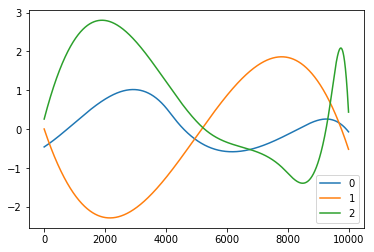

In [64]:
# Sensitivities
timespan = 10000
sens = fk.get_sensitivities(timespan, sens_type)
sens.plot()

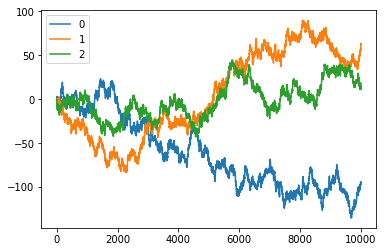

In [65]:
# Factors
factors = fk.get_factors(timespan)
factors.cumsum(axis=0).plot()

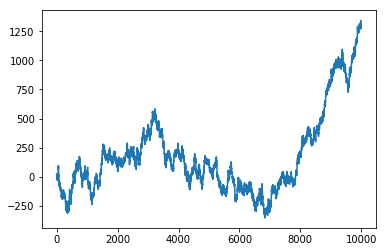

In [66]:
# Returns
returns = fk.get_returns(timespan, factors, sens, return_noise)
returns.cumsum().plot()

In [67]:
# Dictionaries to record the mse and the weighted accuracy
performance_record_mse = {}
performance_record_wacc = {}
# To have consistent colors in the plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Constant regression

In [68]:
estimated_sensitivities_cr = fk.estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,0.228762,-0.190039,0.853554
1,0.228762,-0.190039,0.853554
2,0.228762,-0.190039,0.853554
3,0.228762,-0.190039,0.853554
4,0.228762,-0.190039,0.853554
5,0.228762,-0.190039,0.853554
6,0.228762,-0.190039,0.853554
7,0.228762,-0.190039,0.853554
8,0.228762,-0.190039,0.853554
9,0.228762,-0.190039,0.853554


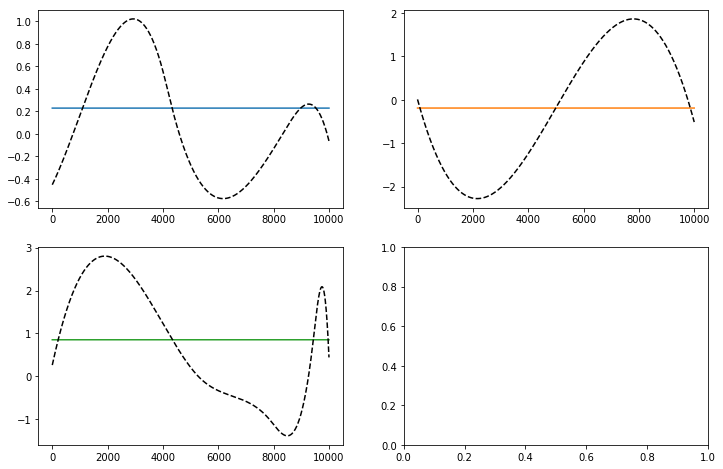

In [69]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_cr, colors)

MSE for Constant OLS, assuming the factors known: 102.7372032924406
Weighted accuracy for Constant OLS, assuming the factors known: 0.7070922592000553


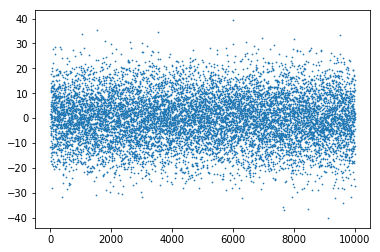

In [70]:
fk.plot_prediction_performance(factors, returns, estimated_sensitivities_cr, "Constant OLS", 
                            performance_record_mse, performance_record_wacc)

## Rolling regression

In [71]:
window = rolling_ols_window
estimated_sensitivities_rr = fk.estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
499,-0.795555,-0.958734,1.227192
500,-0.794721,-0.959713,1.224388
501,-0.830154,-0.940967,1.199029
502,-0.857893,-0.999967,1.221848
503,-0.838265,-0.994920,1.221890
504,-0.813612,-1.017613,1.250351
505,-0.800653,-1.020297,1.233574
506,-0.797351,-1.022232,1.238923
507,-0.826265,-1.027379,1.258302
508,-0.850631,-0.992990,1.286465


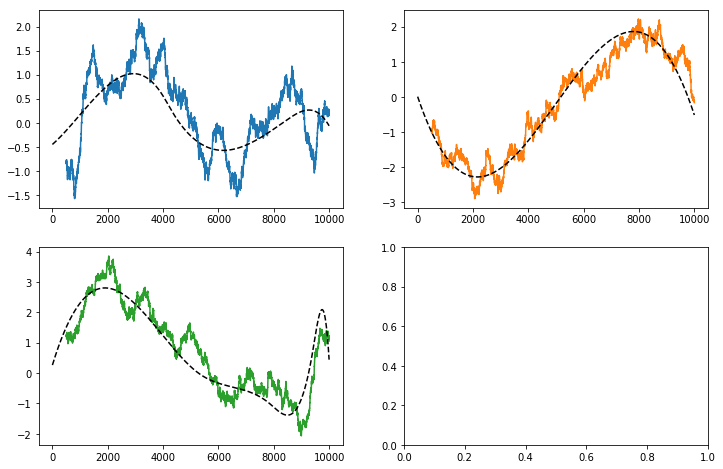

In [72]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling OLS, assuming the factors known: 99.62301739313942
Weighted accuracy for Rolling OLS, assuming the factors known: 1.362832535671929


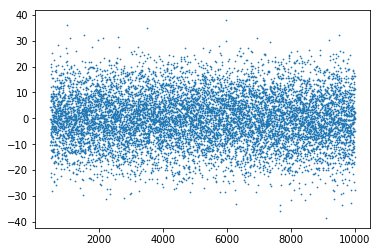

In [73]:
fk.plot_prediction_performance(factors.iloc[window-1:,:], 
                               returns.iloc[window-1:], 
                               estimated_sensitivities_rr, 
                               "Rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Exponential rolling regression

In [74]:
estimated_sensitivities_err = fk.estimate_sensitivities_err(factors, returns, exp_rolling_ols_lambda)

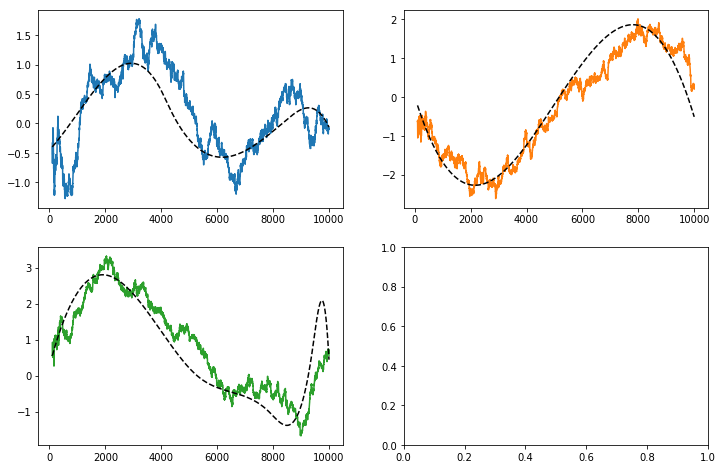

In [75]:
fk.plot_estimated_sensitivities(sens.iloc[100:,:], estimated_sensitivities_err.iloc[100:,:], colors)

MSE for Exponential rolling OLS, assuming the factors known: 99.54321337742473
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 1.3593952148541473


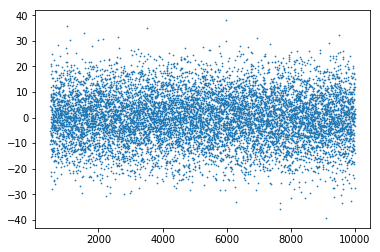

In [76]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_err.iloc[burn_period:,:], 
                               "Exponential rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Kalman filter

In [77]:
covariance_ratio = kalman_covariance_ratio
estimated_sensitivities_kf = fk.estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,-0.017429,0.547421,0.357178
1,-0.926867,-0.351133,1.611969
2,-2.432911,2.990106,0.168626
3,-1.556730,3.119390,0.889970
4,-1.926222,4.075414,-0.178206
5,-4.558181,5.208896,0.988346
6,-3.551335,5.080686,1.527273
7,0.127918,4.314427,0.632716
8,0.256127,3.181600,-0.927854
9,-1.199339,2.934926,-0.592605


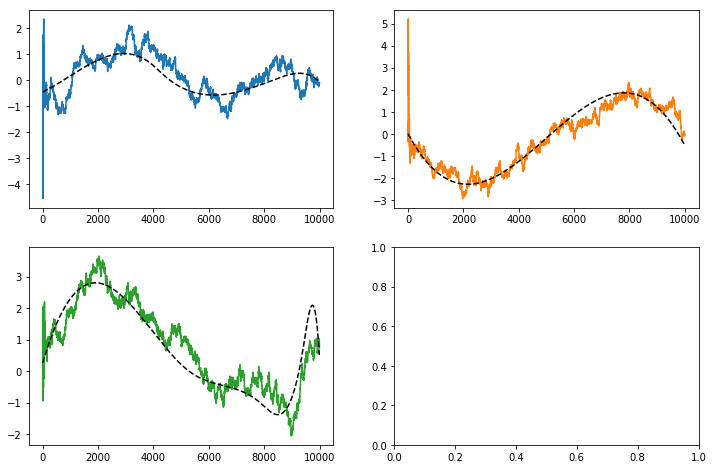

In [78]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 99.50743829933637
Weighted accuracy for Kalman, assuming the factors known: 1.377505192825382


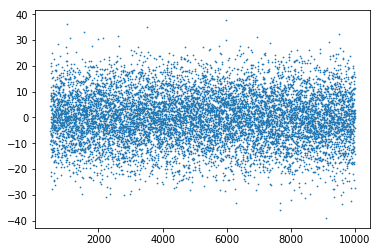

In [79]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf.iloc[burn_period:,:], 
                               "Kalman",
                               performance_record_mse,
                               performance_record_wacc)

In [80]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = fk.estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


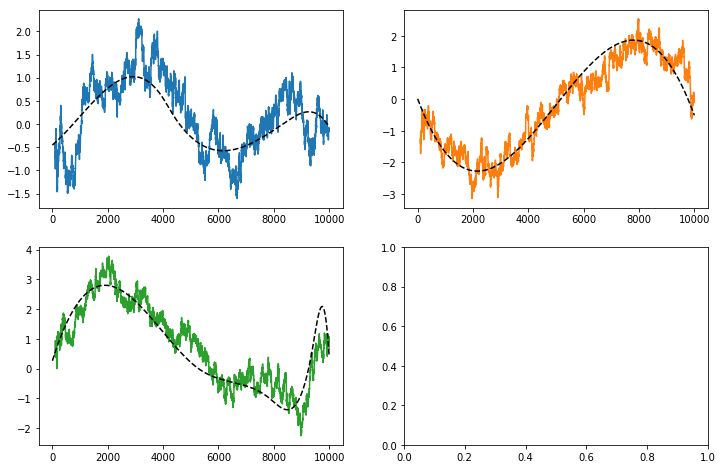

In [81]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 99.56297172092215
Weighted accuracy for Kalman naive trend, assuming the factors known: 1.3527419086964305


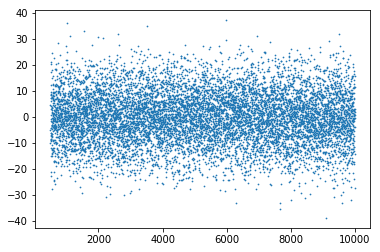

In [82]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_kf_ntc.iloc[burn_period:,:], 
                               "Kalman naive trend",
                               performance_record_mse,
                               performance_record_wacc)

## Stochastic trend Kalman filter

In [83]:
estimated_sensitivities_stkf = fk.estimate_sensitivities_stkf(factors, returns, stkf_covariance_ratio)
estimated_sensitivities_stkf

,0,1,2
0,-0.017429,0.547421,0.357178
1,-1.044188,-0.519471,1.742915
2,-3.404224,5.751618,3.534239
3,-6.475468,8.014177,2.068147
4,-3.392845,12.812236,-4.518014
5,-21.568607,22.306952,2.112771
6,-13.185277,25.413748,8.874067
7,-1.009732,29.835138,-1.026120
8,-2.122075,9.378372,-9.704825
9,-2.116644,0.608498,-2.943422


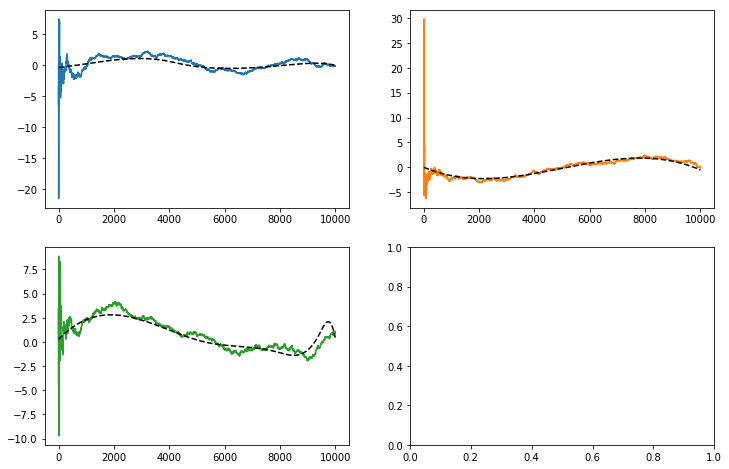

In [84]:
fk.plot_estimated_sensitivities(sens, estimated_sensitivities_stkf, colors)

MSE for Kalman stoch trend, assuming the factors known: 99.66751835096761
Weighted accuracy for Kalman stoch trend, assuming the factors known: 1.4378389719728242


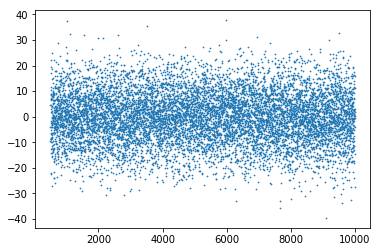

In [85]:
fk.plot_prediction_performance(factors.iloc[burn_period:,:], 
                               returns.iloc[burn_period:], 
                               estimated_sensitivities_stkf.iloc[burn_period:,:], 
                               "Kalman stoch trend",
                               performance_record_mse,
                               performance_record_wacc)

## Performance summary

In [86]:
pd.Series(performance_record_mse).sort_values()

Kalman                      99.507438
Exponential rolling OLS     99.543213
Kalman naive trend          99.562972
Rolling OLS                 99.623017
Kalman stoch trend          99.667518
Constant OLS               102.737203
dtype: float64

In [87]:
pd.Series(performance_record_wacc).sort_values(ascending=False)

Kalman stoch trend         1.437839
Kalman                     1.377505
Rolling OLS                1.362833
Exponential rolling OLS    1.359395
Kalman naive trend         1.352742
Constant OLS               0.707092
dtype: float64

## Optimisation of the hyperparameters

### Rolling OLS

In [34]:
importlib.reload(fk)
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Rolling OLS", 
                                                     100,
                                                     timespan,
                                                     sens_type,
                                                     return_noise,
                                                     rolling_ols_window=[100, 200, 500, 999],
                                                                             )

3
1
2
5
4
0
7
8
9
10
11
13
12
14
15
18
16
17
6
19
22
20
21
23
24
25
27
26
28
29
31
30
33
34
32
35
36
38
37
39
40
46
42
43
44
45
41
47
48
49
52
50
51
53
55
54
56
57
58
59
61
62
60
63
64
65
67
66
68
70
71
73
69
72
74
75
78
76
77
80
81
79
83
82
84
85
86
87
89
90
91
88
92
95
93
94
96
97
99
98


In [35]:
performance_record_wacc.describe()

,Rolling OLS - {'rolling_ols_window': 100},Rolling OLS - {'rolling_ols_window': 200},Rolling OLS - {'rolling_ols_window': 500},Rolling OLS - {'rolling_ols_window': 999}
count,100.000000,100.000000,100.000000,100.000000
mean,1.001627,1.118846,1.197600,1.171238
std,0.922203,0.912357,0.886742,0.839198
min,-0.085004,0.129005,0.169276,0.165902
25%,0.360456,0.495725,0.589379,0.570226
50%,0.642546,0.792380,0.891710,0.894549
75%,1.475706,1.678306,1.672339,1.553603
max,4.160679,4.229614,4.291477,4.208999


In [36]:
importlib.reload(fk)
fk.compute_t_stat(performance_record_wacc)

Rolling OLS - {'rolling_ols_window': 100}     0.000000
Rolling OLS - {'rolling_ols_window': 200}    13.893225
Rolling OLS - {'rolling_ols_window': 500}    13.593986
Rolling OLS - {'rolling_ols_window': 999}     7.873730
dtype: float64

### Exponential rolling OLS

In [38]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Exponential rolling OLS", 100, 
                                                    timespan, sens_type, return_noise, 
                                                    exp_rolling_ols_lambda=[0.0002, 0.0005, 0.001, 0.002, 0.005])

4
0
1
2
3
5
7
6
8
9
10
11
12
13
15
16
17
18
19
20
14
21
22
23
26
24
25
31
28
27
29
30
32
33
34
35
37
38
39
40
36
41
42
43
44
45
46
48
49
50
51
52
47
54
53
55
56
57
60
58
61
59
62
65
63
64
66
67
70
69
71
72
73
68
74
75
76
77
78
79
82
81
80
83
84
85
86
87
88
90
91
92
94
93
89
95
96
97
98
99


In [39]:
performance_record_wacc.describe()

,Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.0002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.0005},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.001},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002},Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.881217,1.038964,1.151622,1.213989,1.204991
std,0.691496,0.726908,0.768750,0.817930,0.872962
min,-0.025190,0.162303,0.145513,0.054789,0.043073
25%,0.407211,0.533501,0.597029,0.619496,0.572025
50%,0.679387,0.837235,0.895325,1.000492,0.963435
75%,1.175822,1.405188,1.484255,1.660121,1.716423
max,3.176656,3.183792,3.305774,3.579941,3.724684


In [40]:
fk.compute_t_stat(performance_record_wacc)

Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.0002}    0.000000
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.0005}    9.350801
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.001}     9.753457
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.002}     9.477835
Exponential rolling OLS - {'exp_rolling_ols_lambda': 0.005}     7.588872
dtype: float64

### Kalman

In [47]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman", 100, 
                                                    timespan, sens_type, return_noise, 
                                                    kalman_covariance_ratio=[1e-6, 2e-6, 5e-6, 1e-5, 2e-5])

4
1
2
3
0
6
8
7
5
9
12
10
11
13
14
18
15
17
16
19
20
21
23
22
24
25
26
28
27
29
30
31
32
33
34
35
36
37
38
39
42
43
40
41
44
45
47
46
48
49
50
52
54
53
51
55
58
57
56
59
60
61
62
64
63
67
66
68
65
69
71
72
70
74
73
76
75
78
77
79
80
82
81
83
84
86
85
87
88
89
90
92
91
93
94
95
97
96
99
98


In [48]:
performance_record_wacc.describe()

,Kalman - {'kalman_covariance_ratio': 1e-05},Kalman - {'kalman_covariance_ratio': 1e-06},Kalman - {'kalman_covariance_ratio': 2e-05},Kalman - {'kalman_covariance_ratio': 2e-06},Kalman - {'kalman_covariance_ratio': 5e-06}
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.106377,1.024379,1.101206,1.073209,1.105725
std,0.775382,0.719332,0.792293,0.731802,0.759956
min,0.151696,0.160668,0.107292,0.190965,0.190487
25%,0.575047,0.531973,0.542758,0.562249,0.561750
50%,0.833701,0.783441,0.838610,0.812895,0.831215
75%,1.442849,1.371610,1.441091,1.465025,1.445165
max,3.838639,3.545852,3.909182,3.650566,3.784909


In [49]:
fk.compute_t_stat(performance_record_wacc)

Kalman - {'kalman_covariance_ratio': 1e-05}    0.000000
Kalman - {'kalman_covariance_ratio': 1e-06}   -5.567162
Kalman - {'kalman_covariance_ratio': 2e-05}   -1.047903
Kalman - {'kalman_covariance_ratio': 2e-06}   -3.127223
Kalman - {'kalman_covariance_ratio': 5e-06}   -0.126818
dtype: float64

### Kalman naive trend

In [51]:
importlib.reload(fk)
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman naive trend", 100, timespan,
                                                    sens_type, return_noise, kalman_covariance_ratio=[1e-5],
                                                               nt_factor=[.1, .2, .5, 1.0, 2.0], 
                                                               nt_window=[500])

0
5
1
2
3
4
6
7
9
8
11
12
13
10
15
14
17
16
20
19
18
21
22
23
25
24
27
26
29
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
45
47
48
49
50
51
52
53
54
55
56
57
59
58
60
61
62
64
63
65
67
68
69
66
71
72
70
74
73
76
75
77
78
79
81
80
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [52]:
performance_record_wacc.describe()

,"Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.1, 'nt_window': 500}","Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.2, 'nt_window': 500}","Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.5, 'nt_window': 500}","Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 1.0, 'nt_window': 500}","Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 2.0, 'nt_window': 500}"
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.165366,1.157867,1.141020,1.103449,1.032236
std,0.797868,0.802067,0.814403,0.829243,0.835992
min,0.245241,0.216231,0.172335,0.112060,0.045518
25%,0.544790,0.533159,0.513158,0.441536,0.391592
50%,0.896079,0.892924,0.891016,0.852515,0.751003
75%,1.631463,1.626974,1.556596,1.495226,1.516918
max,3.431528,3.400049,3.448393,3.353572,3.321509


In [53]:
fk.compute_t_stat(performance_record_wacc)

Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.1, 'nt_window': 500}     0.000000
Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.2, 'nt_window': 500}    -3.273245
Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 0.5, 'nt_window': 500}    -4.602409
Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 1.0, 'nt_window': 500}    -8.003753
Kalman naive trend - {'kalman_covariance_ratio': 1e-05, 'nt_factor': 2.0, 'nt_window': 500}   -12.199575
dtype: float64

### Kalman stochastic trend

In [60]:
performance_record_mse, performance_record_wacc = fk.compare_hyperparameters_mp("Kalman stoch trend", 100, timespan,
                                                    sens_type, return_noise, stkf_covariance_ratio=[5e-12, 1e-11, 2e-11, 5e-11, 1e-10])

4
2
3
6
5
0
1
7
9
13
10
8
11
12
14
16
15
18
20
17
19
21
23
22
24
25
26
27
28
29
30
33
34
32
31
35
36
38
37
39
41
40
43
42
44
45
48
46
47
50
49
51
53
55
52
54
56
57
58
59
61
60
62
63
64
65
66
67
68
69
70
71
73
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
92
91
93
95
94
96
97
98
99


In [61]:
performance_record_wacc.describe()

,Kalman stoch trend - {'stkf_covariance_ratio': 1e-10},Kalman stoch trend - {'stkf_covariance_ratio': 1e-11},Kalman stoch trend - {'stkf_covariance_ratio': 2e-11},Kalman stoch trend - {'stkf_covariance_ratio': 5e-11},Kalman stoch trend - {'stkf_covariance_ratio': 5e-12}
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.170997,1.193169,1.191507,1.184288,1.197811
std,0.912340,0.875588,0.888480,0.901192,0.862307
min,-0.055039,0.121120,0.025969,-0.041018,0.163609
25%,0.500052,0.563633,0.568345,0.542641,0.612811
50%,0.854659,0.906524,0.893212,0.893562,0.875999
75%,1.526294,1.558894,1.571529,1.549953,1.569276
max,4.366091,4.333697,4.351284,4.340538,4.343606


In [62]:
fk.compute_t_stat(performance_record_wacc)

Kalman stoch trend - {'stkf_covariance_ratio': 1e-10}    0.000000
Kalman stoch trend - {'stkf_covariance_ratio': 1e-11}    2.554487
Kalman stoch trend - {'stkf_covariance_ratio': 2e-11}    3.060238
Kalman stoch trend - {'stkf_covariance_ratio': 5e-11}    3.401114
Kalman stoch trend - {'stkf_covariance_ratio': 5e-12}    2.546697
dtype: float64

## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [88]:
importlib.reload(fk)
num_samples = 5000
algo_parameters = {'rolling_ols_window': rolling_ols_window,
                   'exp_rolling_ols_lambda': exp_rolling_ols_lambda,
                   'kalman_covariance_ratio': kalman_covariance_ratio,
                   'stkf_covariance_ratio': stkf_covariance_ratio,
                  }
performance_record_mse, performance_record_wacc = fk.get_performance_data(num_samples, 
                                                              sens_type, timespan, return_noise, algo_parameters)

6
3
4
0
5
2
1
7
9
13
8
11
10
12
14
15
20
18
16
19
17
21
24
23
25
22
26
27
28
32
34
29
31
33
30
36
35
37
39
38
40
41
42
43
45
44
46
47
48
49
54
52
50
51
53
55
57
56
61
60
59
58
62
63
65
64
66
69
68
67
70
71
75
73
74
72
76
77
78
79
80
81
82
83
85
84
86
87
89
90
88
91
92
96
97
95
93
94
98
99
104
101
103
102
100
110
105
106
109
108
107
111
112
115
113
118
114
116
117
119
121
124
120
123
125
122
126
127
130
132
128
129
131
133
135
134
139
137
138
136
142
140
141
143
144
145
146
147
148
150
149
152
151
153
156
154
155
158
157
159
160
161
162
165
163
164
166
167
168
169
170
174
172
171
173
175
177
176
179
180
181
178
182
184
183
188
187
185
186
189
191
190
194
195
192
193
196
198
197
199
201
200
202
205
203
204
206
208
207
209
210
211
213
214
212
216
215
217
219
220
218
223
221
222
224
225
226
229
230
227
228
231
233
235
234
232
236
237
238
239
241
242
244
240
243
245
247
246
248
249
251
250
252
256
253
257
254
258
255
259
260
263
261
264
265
262
271
266
268
272
270
267
269
274
275
273
279
27

1860
1862
1863
1865
1867
1868
1864
1866
1869
1872
1871
1873
1870
1874
1875
1876
1877
1880
1881
1879
1878
1882
1883
1884
1887
1885
1889
1886
1888
1890
1891
1892
1895
1894
1896
1893
1897
1898
1901
1903
1900
1902
1899
1905
1904
1910
1909
1907
1906
1908
1911
1914
1916
1913
1912
1915
1917
1922
1924
1923
1918
1919
1921
1920
1925
1927
1926
1929
1928
1930
1931
1932
1933
1935
1936
1937
1938
1934
1940
1939
1942
1944
1941
1945
1943
1946
1948
1949
1951
1950
1947
1952
1953
1954
1955
1956
1958
1957
1959
1960
1961
1965
1963
1962
1964
1966
1967
1969
1970
1968
1971
1973
1972
1974
1975
1976
1977
1978
1980
1979
1981
1984
1982
1985
1983
1987
1986
1988
1989
1991
1990
1994
1992
1993
1995
1996
2001
1999
2000
1998
1997
2002
2005
2003
2007
2008
2006
2004
2009
2010
2012
2011
2014
2013
2015
2017
2016
2021
2019
2018
2020
2022
2023
2024
2026
2027
2029
2028
2025
2030
2031
2032
2035
2036
2033
2034
2037
2038
2040
2041
2042
2039
2043
2044
2045
2047
2046
2048
2050
2049
2051
2052
2053
2057
2054
2056
2055
2058
2059
2060


3501
3500
3503
3502
3505
3504
3506
3508
3509
3507
3511
3510
3512
3513
3514
3515
3516
3518
3519
3520
3517
3521
3523
3522
3527
3526
3524
3525
3528
3529
3530
3534
3533
3531
3532
3535
3538
3536
3541
3540
3537
3539
3542
3544
3543
3546
3548
3547
3545
3549
3550
3555
3551
3554
3552
3553
3556
3557
3560
3558
3559
3562
3561
3563
3565
3564
3567
3566
3568
3569
3571
3572
3575
3570
3576
3573
3574
3579
3578
3577
3582
3581
3580
3583
3585
3584
3586
3587
3589
3588
3590
3591
3593
3592
3594
3595
3596
3597
3598
3599
3601
3602
3600
3604
3603
3605
3607
3608
3609
3610
3611
3606
3612
3613
3615
3617
3618
3614
3616
3619
3623
3624
3620
3625
3621
3622
3626
3627
3628
3631
3630
3629
3632
3633
3634
3638
3636
3639
3637
3635
3640
3643
3641
3642
3644
3646
3645
3647
3649
3651
3650
3648
3653
3652
3654
3655
3660
3657
3659
3658
3656
3661
3663
3662
3664
3665
3666
3667
3668
3669
3672
3671
3670
3673
3674
3675
3676
3679
3681
3677
3678
3680
3683
3682
3685
3684
3687
3688
3686
3689
3692
3691
3690
3694
3693
3695
3696
3699
3697
3698


In [89]:
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman stoch trend,Rolling OLS
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.863474,1.244611,1.256545,1.248758,1.243336
std,0.738970,0.870724,0.896305,0.878751,0.899726
min,-0.260965,-0.130899,-0.124679,-0.086264,-0.145109
25%,0.384229,0.621582,0.610617,0.618729,0.592325
50%,0.610972,0.952319,0.959262,0.954060,0.939429
75%,1.088371,1.617080,1.649193,1.618615,1.636816
max,4.819668,5.435227,5.531880,5.476420,5.525660


In [102]:
importlib.reload(fk)
import warnings
warnings.filterwarnings('ignore')
fk.performance_summary(performance_record_wacc, "Weighted accuracy")

,Weighted accuracy,t-test differential p-value,Wilcoxon test differential p-value
Kalman,1.256545,2.149515e-14,8.132188e-06
Kalman stoch trend,1.248758,1.213178e-06,2.653319e-08
Exponential rolling OLS,1.244611,2.459756e-01,1.598059e-02
Rolling OLS,1.243336,0.000000e+00,0.000000e+00
Constant OLS,0.863474,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001E5FD438>,
      dtype=object)

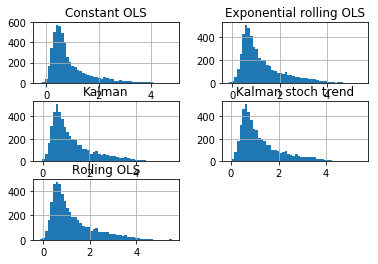

In [90]:
performance_record_wacc.hist(bins=50)

In [91]:
fk.compute_t_stat(performance_record_wacc, reference='Rolling OLS')

Constant OLS              -57.868659
Exponential rolling OLS     1.160316
Kalman                     16.044112
Kalman stoch trend          4.938294
Rolling OLS                 0.000000
dtype: float64

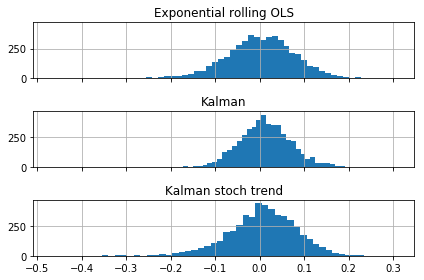

In [92]:
fk.plot_t_stat_differences(performance_record_wacc.iloc[:,1:], reference='Rolling OLS')

In [93]:
fk.compute_wilcoxon_pvalue(performance_record_wacc, reference='Rolling OLS')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS               0.000000e+00
Exponential rolling OLS    1.598059e-02
Kalman                     4.938557e-51
Kalman stoch trend         1.453886e-14
Rolling OLS                         NaN
dtype: float64

In [94]:
fk.compute_wilcoxon_pvalue(performance_record_wacc, reference='Kalman')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS               0.000000e+00
Exponential rolling OLS    7.183313e-27
Kalman                              NaN
Kalman stoch trend         8.132188e-06
Rolling OLS                4.938557e-51
dtype: float64

In [95]:
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman stoch trend,Rolling OLS
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,103.455860,100.983357,100.866159,101.238576,100.970314
std,4.499702,1.804941,1.618723,1.913367,1.643896
min,95.735472,95.907937,96.063340,96.081357,96.149918
25%,100.568120,99.815487,99.795286,100.013097,99.871743
50%,102.275834,100.867151,100.808825,101.085322,100.891762
75%,105.010003,102.014625,101.871583,102.249869,101.986955
max,136.842138,112.944277,110.348487,115.239635,111.558678


In [96]:
fk.compute_t_stat(performance_record_mse, reference='Rolling OLS')

Constant OLS               46.694995
Exponential rolling OLS     2.331125
Kalman                    -52.890887
Kalman stoch trend         33.405384
Rolling OLS                 0.000000
dtype: float64

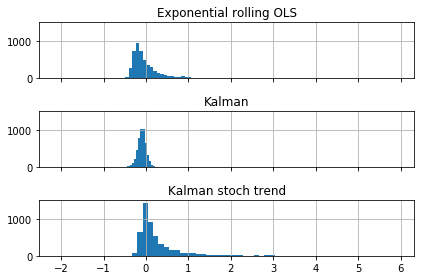

In [97]:
fk.plot_t_stat_differences(performance_record_mse.iloc[:,1:], reference='Rolling OLS')

In [98]:
fk.compute_wilcoxon_pvalue(performance_record_mse, reference='Rolling OLS')

C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sam\Anaconda2\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Constant OLS                0.000000e+00
Exponential rolling OLS     4.889889e-42
Kalman                      0.000000e+00
Kalman stoch trend         2.674609e-269
Rolling OLS                          NaN
dtype: float64

## Save data

In [101]:
import pickle
with open('20190315-performance_record-largenoise.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [1264]:
with open('performance_record.pickle', 'rb') as f:
    ls = pickle.load(f)
ls

{'MSE':       Constant OLS    Kalman  Kalman Bentz trend  Kalman naive trend  \
 0         1.642084  0.959128            0.969325            0.934450   
 1         1.652597  0.953329            0.964440            0.928491   
 2         1.672936  0.956445            0.966112            0.932220   
 3         1.673412  0.957570            0.967425            0.932708   
 4         1.673309  0.965016            0.974735            0.940621   
 5         1.683193  0.963870            0.972889            0.940625   
 6         1.654992  0.967241            0.977574            0.942468   
 7         1.658842  0.940273            0.949614            0.916005   
 8         1.660779  0.952864            0.963289            0.928959   
 9         1.661458  0.964175            0.974029            0.939953   
 10        1.666550  0.978255            0.987707            0.952743   
 11        1.682632  0.947483            0.958717            0.923289   
 12        1.645867  0.966099            0.9

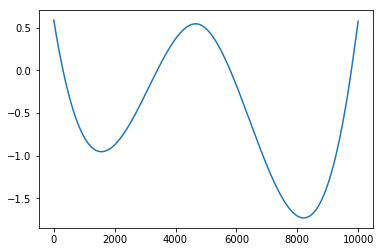

In [747]:
random_sensitivity = create_random_sensitivity(timespan)
#values = splev(factors.index, random_sensitivity)

plt.figure()
random_sensitivity.plot()
#plt.plot(factors.index, values)
plt.show()